In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16 # Example pre-trained models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:

# --- 1. Configuration and Setup ---
# Define paths
DATASET_DIR = 'dataset'
TRAIN_REAL_DIR = os.path.join(DATASET_DIR, 'training_real')
TRAIN_FAKE_DIR = os.path.join(DATASET_DIR, 'training_fake')
TEST_DIR = 'test' # Sibling to dataset folder

TRAIN_CSV_PATH = 'train.csv'
TEST_CSV_PATH = 'test.csv'

# Image parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
NUM_CLASSES = 2 # Real and Fake
EPOCHS = 20 # You might need to adjust this based on convergence
LEARNING_RATE = 0.001


In [3]:
# Load train.csv
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    print(f"train_df head:\n{train_df.head()}")
    print(f"train_df info:\n{train_df.info()}")
    print(f"train_df label counts:\n{train_df['label'].value_counts()}")
except FileNotFoundError:
    print(f"Error: {TRAIN_CSV_PATH} not found. Please ensure the CSV file is in the correct directory.")
    exit()

# Load test.csv
try:
    test_df = pd.read_csv(TEST_CSV_PATH)
    print(f"\ntest_df head:\n{test_df.head()}")
    print(f"test_df info:\n{test_df.info()}")
except FileNotFoundError:
    print(f"Error: {TEST_CSV_PATH} not found. Please ensure the CSV file is in the correct directory.")
    exit()


train_df head:
   file_id  label
0        0      0
1        1      0
2        2      0
3        3      0
4        4      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   file_id  1709 non-null   int64
 1   label    1709 non-null   int64
dtypes: int64(2)
memory usage: 26.8 KB
train_df info:
None
train_df label counts:
label
1    949
0    760
Name: count, dtype: int64

test_df head:
   file_id
0        0
1        1
2        2
3        3
4        4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   file_id  332 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB
test_df info:
None


In [4]:
# Create a full path column for training images in train_df
# Assuming file_id in train.csv corresponds to the image name (e.g., '0.jpg')
# And assuming '0' is 'real' and '1' is 'fake' based on common practice for binary classification
# We need to map file_id to the correct subdirectory (training_real or training_fake)
# Since the train.csv only gives file_id and label, and not the source folder,
# we need to infer the folder structure.
# A more robust approach would be to glob all images and then match with train_df.

# Let's list all files in training_real and training_fake and create a combined DataFrame
# and then merge with train_df.

# Function to get file paths and corresponding labels
def get_image_paths_and_labels(base_dir, label_mapping):
    data = []
    for label_name, label_id in label_mapping.items():
        folder_path = os.path.join(base_dir, label_name)
        if not os.path.exists(folder_path):
            print(f"Warning: Directory {folder_path} not found. Please check your dataset structure.")
            continue
        for img_name in os.listdir(folder_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')): # Filter for image files
                data.append({'file_id': os.path.splitext(img_name)[0], 'file_path': os.path.join(folder_path, img_name), 'label': label_id})
    return pd.DataFrame(data)


In [5]:

# Assuming 'training_real' corresponds to label 0 and 'training_fake' to label 1
label_mapping = {'training_real': 0, 'training_fake': 1}
all_train_images_df = get_image_paths_and_labels(DATASET_DIR, label_mapping)

# Convert file_id to string for merging (if train_df's file_id is int)
train_df['file_id'] = train_df['file_id'].astype(str)
all_train_images_df['file_id'] = all_train_images_df['file_id'].astype(str)

# Merge with the provided train_df to ensure correct labels based on train.csv
# This handles cases where train.csv might contradict the folder structure (unlikely but good for robustness)
merged_train_df = pd.merge(all_train_images_df[['file_id', 'file_path']], train_df, on='file_id', how='inner')
merged_train_df['label'] = merged_train_df['label'].astype(str) # Convert labels to string for flow_from_dataframe

print(f"\nMerged Train DataFrame head:\n{merged_train_df.head()}")
print(f"Merged Train DataFrame info:\n{merged_train_df.info()}")
print(f"Merged Train DataFrame label counts:\n{merged_train_df['label'].value_counts()}")



Merged Train DataFrame head:
  file_id                       file_path label
0    1000  dataset\training_real\1000.jpg     1
1    1001  dataset\training_real\1001.jpg     1
2    1002  dataset\training_real\1002.jpg     1
3    1003  dataset\training_real\1003.jpg     1
4    1004  dataset\training_real\1004.jpg     1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_id    1709 non-null   object
 1   file_path  1709 non-null   object
 2   label      1709 non-null   object
dtypes: object(3)
memory usage: 40.2+ KB
Merged Train DataFrame info:
None
Merged Train DataFrame label counts:
label
1    949
0    760
Name: count, dtype: int64


In [6]:

if merged_train_df.empty:
    print("Error: Merged training DataFrame is empty. Check file_id matching between CSV and image filenames.")
    exit()

# Split training data for validation
train_df_split, val_df_split = train_test_split(merged_train_df, test_size=0.2, random_state=42, stratify=merged_train_df['label'])

print(f"\nTrain split size: {len(train_df_split)}")
print(f"Validation split size: {len(val_df_split)}")
print(f"Train split label counts:\n{train_df_split['label'].value_counts()}")
print(f"Validation split label counts:\n{val_df_split['label'].value_counts()}")




Train split size: 1367
Validation split size: 342
Train split label counts:
label
1    759
0    608
Name: count, dtype: int64
Validation split label counts:
label
1    190
0    152
Name: count, dtype: int64


In [7]:
# Image Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [8]:
val_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for test

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_split,
    x_col='file_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary', # Since we have 2 classes
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df_split,
    x_col='file_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # No need to shuffle validation data
)

Found 1367 validated image filenames belonging to 2 classes.
Found 342 validated image filenames belonging to 2 classes.


In [10]:
# Prepare test data for prediction
# Create full paths for test images
test_df['file_path'] = test_df['file_id'].apply(lambda x: os.path.join(TEST_DIR, str(x) + '.jpg')) # Assuming .jpg extension for test images

# Verify if test image files exist
# This helps in debugging if flow_from_dataframe fails
missing_test_files = [path for path in test_df['file_path'] if not os.path.exists(path)]
if missing_test_files:
    print(f"\nWarning: {len(missing_test_files)} test files not found. First 5 missing: {missing_test_files[:5]}")
    # You might want to filter these out or handle them
    test_df = test_df[test_df['file_path'].apply(os.path.exists)]
    if test_df.empty:
        print("Error: No valid test images found after filtering missing files.")
        exit()
else:
    print("\nAll test files found.")


All test files found.


In [11]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col=None, # No labels for test set
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None, # Important for prediction
    shuffle=False
)

Found 332 validated image filenames.


In [12]:
# --- 3. Model Definition: From Scratch ---
def create_scratch_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
# --- 4. Model Definition: Pre-trained (Transfer Learning) ---

def create_pretrained_model(base_model_name='ResNet50', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}. Choose 'ResNet50' or 'VGG16'.")

    # Freeze the layers of the base model
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
# --- 5. Training and Evaluation ---

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_scratch = ModelCheckpoint('best_scratch_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
model_checkpoint_pretrained = ModelCheckpoint('best_pretrained_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')


In [15]:
# --- Model 1: From Scratch ---
print("\n--- Training Model From Scratch ---")
scratch_model = create_scratch_model()
scratch_model.summary()

history_scratch = scratch_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint_scratch]
)

print("\n--- Evaluating Scratch Model ---")
# Load the best saved model for evaluation
best_scratch_model = tf.keras.models.load_model('best_scratch_model.keras')
loss_scratch, accuracy_scratch = best_scratch_model.evaluate(validation_generator)
print(f"Scratch Model Validation Loss: {loss_scratch:.4f}")
print(f"Scratch Model Validation Accuracy: {accuracy_scratch:.4f}")


--- Training Model From Scratch ---


C:\Users\manju\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,209 (24.86 MB)

 Trainable params: 6,517,249 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)

C:\Users\manju\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5176 - loss: 0.9981 - val_accuracy: 0.5562 - val_loss: 2.8174
Epoch 2/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.5625 - loss: 0.8812

C:\Users\manju\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5625 - loss: 0.8812 - val_accuracy: 0.5562 - val_loss: 2.7814
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 822ms/step - accuracy: 0.5064 - loss: 0.9395 - val_accuracy: 0.5562 - val_loss: 1.7215
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5938 - loss: 0.9456 - val_accuracy: 0.5562 - val_loss: 1.6796
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 886ms/step - accuracy: 0.5648 - loss: 0.8071 - val_accuracy: 0.5562 - val_loss: 1.2156
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5312 - loss: 0.7851 - val_accuracy: 0.5562 - val_loss: 1.2304
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 871ms/step - accuracy: 0.5288 - loss: 0.8258 - val_accuracy: 0.5562 - val_loss: 1.0265
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.4375 - loss: 0.8854 - val_accuracy: 0.5562 - val_loss: 1.0543
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 872ms/step - accuracy: 0.5408 - loss: 0.8039 - val_accuracy: 0.5562 - val_

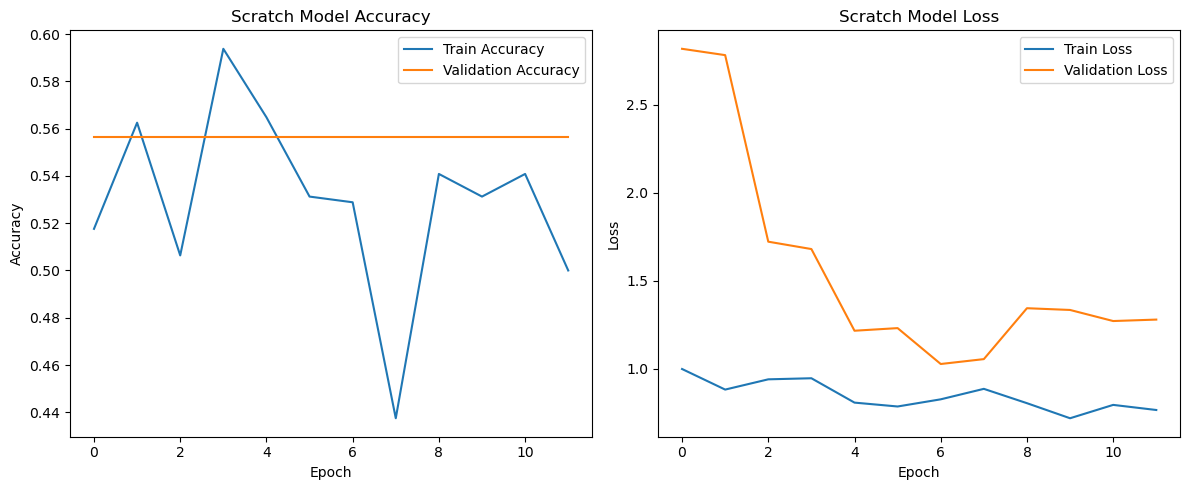

In [16]:
# --- Plot Training History (Scratch Model) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'], label='Train Accuracy')
plt.plot(history_scratch.history['val_accuracy'], label='Validation Accuracy')
plt.title('Scratch Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'], label='Train Loss')
plt.plot(history_scratch.history['val_loss'], label='Validation Loss')
plt.title('Scratch Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# --- Model 2: Pre-trained (ResNet50) ---
print("\n--- Training Pre-trained Model (ResNet50) ---")
# Reset generators for pre-trained model (especially if batching/shuffling matters)
train_generator.reset()
validation_generator.reset()

pretrained_model = create_pretrained_model(base_model_name='ResNet50')
pretrained_model.summary()

history_pretrained = pretrained_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint_pretrained]
)

print("\n--- Evaluating Pre-trained Model ---")
# Load the best saved model for evaluation
best_pretrained_model = tf.keras.models.load_model('best_pretrained_model.keras')
loss_pretrained, accuracy_pretrained = best_pretrained_model.evaluate(validation_generator)
print(f"Pre-trained Model Validation Loss: {loss_pretrained:.4f}")
print(f"Pre-trained Model Validation Accuracy: {accuracy_pretrained:.4f}")


--- Training Pre-trained Model (ResNet50) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,977,857 (121.99 MB)

 Trainable params: 8,389,633 (32.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5049 - loss: 0.8813 - val_accuracy: 0.4281 - val_loss: 0.7407
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.5625 - loss: 0.6930 - val_accuracy: 0.4469 - val_loss: 0.7613
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 964ms/step - accuracy: 0.5116 - loss: 0.7819 - val_accuracy: 0.4437 - val_loss: 1.0319
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.4688 - loss: 0.7514 - val_accuracy: 0.4469 - val_loss: 0.9928
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5243 - loss: 0.7448 - val_accuracy: 0.5969 - val_loss: 0.6772
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.3125 - loss: 0.7985 - val_accuracy: 0.6000 - val_loss: 0.6769
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 961ms/step - accuracy: 0.5401 - loss: 0.7207 - val_accuracy: 0.5562 - val_loss: 1.0685
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.6250 - loss: 0.7734 - val_accuracy: 0.

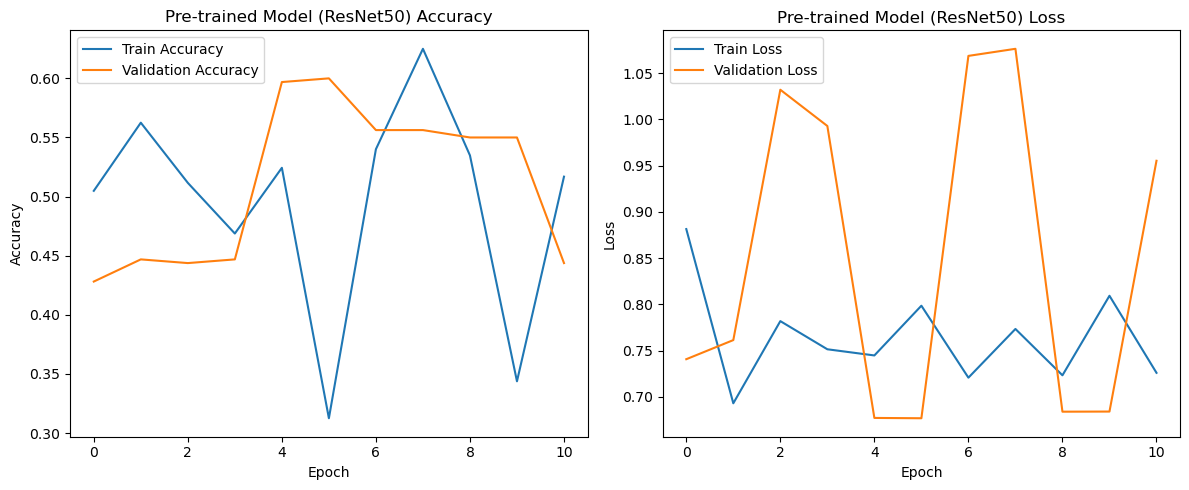

In [18]:
# --- Plot Training History (Pre-trained Model) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['accuracy'], label='Train Accuracy')
plt.plot(history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Pre-trained Model (ResNet50) Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'], label='Train Loss')
plt.plot(history_pretrained.history['val_loss'], label='Validation Loss')
plt.title('Pre-trained Model (ResNet50) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# --- 6. Prediction on Test Set ---

print("\n--- Making Predictions on Test Set ---")

# Ensure test_generator is reset before prediction
test_generator.reset()

# Predictions from Scratch Model
print("\nPredicting with Scratch Model...")
scratch_predictions = best_scratch_model.predict(test_generator)
scratch_predicted_classes = (scratch_predictions > 0.5).astype(int) # Convert probabilities to binary classes

# Predictions from Pre-trained Model
print("Predicting with Pre-trained Model...")
pretrained_predictions = best_pretrained_model.predict(test_generator)
pretrained_predicted_classes = (pretrained_predictions > 0.5).astype(int)

# Create submission files (assuming 'file_id' from test_df needs to be mapped to predictions)
# We need to map the predictions back to the original file_ids.
# test_generator.filenames contains the relative paths, we need to extract file_id.

# Get the mapping of indices to original filenames (file_id.jpg) from the generator
test_filenames = test_generator.filenames
test_file_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_filenames]

# Create submission DataFrame for Scratch Model
submission_scratch_df = pd.DataFrame({
    'file_id': test_file_ids,
    'label': scratch_predicted_classes.flatten() # Flatten to 1D array
})
submission_scratch_df.to_csv('submission_scratch_model.csv', index=False)
print(f"\nSubmission for Scratch Model saved to submission_scratch_model.csv:\n{submission_scratch_df.head()}")
print(f"Scratch Model Predicted Label Counts:\n{submission_scratch_df['label'].value_counts()}")


--- Making Predictions on Test Set ---

Predicting with Scratch Model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step
Predicting with Pre-trained Model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 750ms/step

Submission for Scratch Model saved to submission_scratch_model.csv:
  file_id  label
0       0      1
1       1      1
2       2      1
3       3      1
4       4      1
Scratch Model Predicted Label Counts:
label
1    332
Name: count, dtype: int64


In [20]:
# Create submission DataFrame for Pre-trained Model
submission_pretrained_df = pd.DataFrame({
    'file_id': test_file_ids,
    'label': pretrained_predicted_classes.flatten()
})
submission_pretrained_df.to_csv('submission_pretrained_model.csv', index=False)
print(f"\nSubmission for Pre-trained Model saved to submission_pretrained_model.csv:\n{submission_pretrained_df.head()}")
print(f"Pre-trained Model Predicted Label Counts:\n{submission_pretrained_df['label'].value_counts()}")



Submission for Pre-trained Model saved to submission_pretrained_model.csv:
  file_id  label
0       0      1
1       1      1
2       2      0
3       3      1
4       4      1
Pre-trained Model Predicted Label Counts:
label
1    252
0     80
Name: count, dtype: int64


In [21]:
# --- Comparison Summary ---
print("\n--- Model Comparison Summary ---")
print(f"Scratch Model Validation Accuracy: {accuracy_scratch:.4f}")
print(f"Pre-trained Model (ResNet50) Validation Accuracy: {accuracy_pretrained:.4f}")


--- Model Comparison Summary ---
Scratch Model Validation Accuracy: 0.5556
Pre-trained Model (ResNet50) Validation Accuracy: 0.5936
